In [65]:
import caffe
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import skimage.io as skio
import skvideo.io
from skimage import img_as_ubyte
from skimage.transform import resize
from viz_conv_layers.util import mobilenet_layers, apply_forward_convs, plot_conv_maps, plot_conv_maps_ratio

### Initialize network

In [3]:
net = caffe.Net('mobilenet/mobilenet_deploy.prototxt',
                'mobilenet/mobilenet.caffemodel', caffe.TEST)
video_path = '/var/home/train_cam_full.mp4'

#### Network blob names

In [4]:
net.blobs

OrderedDict([('data', <caffe._caffe.Blob at 0x7f08553222a8>),
             ('conv1', <caffe._caffe.Blob at 0x7f0855249848>),
             ('conv2_1/dw', <caffe._caffe.Blob at 0x7f07b5877938>),
             ('conv2_1/sep', <caffe._caffe.Blob at 0x7f07b58779b0>),
             ('conv2_2/dw', <caffe._caffe.Blob at 0x7f07b5877a28>),
             ('conv2_2/sep', <caffe._caffe.Blob at 0x7f07b5877aa0>),
             ('conv3_1/dw', <caffe._caffe.Blob at 0x7f07b5877b18>),
             ('conv3_1/sep', <caffe._caffe.Blob at 0x7f07b5877b90>),
             ('conv3_2/dw', <caffe._caffe.Blob at 0x7f07b5877c08>),
             ('conv3_2/sep', <caffe._caffe.Blob at 0x7f07b5877c80>),
             ('conv4_1/dw', <caffe._caffe.Blob at 0x7f07b5877cf8>),
             ('conv4_1/sep', <caffe._caffe.Blob at 0x7f07b5877d70>),
             ('conv4_2/dw', <caffe._caffe.Blob at 0x7f07b5877de8>),
             ('conv4_2/sep', <caffe._caffe.Blob at 0x7f07b5877e60>),
             ('conv5_1/dw', <caffe._caffe.Blob at 0x7

### Utility Functions

In [119]:
def create_vreader(path, offset=0):
    vreader = skvideo.io.vreader(path)
    for _ in range(offset):
        next(vreader)
    return vreader

def normalize_mobilenet_input(data):
    data = 0.017 * (data - [123.68, 116.78, 103.94])
    return data

def get_network_outputs(net, data):
    b, c, h, w = net.blobs['data'].data.shape
    # Assume data is untransposed.
    data = np.transpose(data, (0, 3, 1, 2))
    net.blobs['data'].reshape(*data.shape)
    net.blobs['data'].data[...] = data
    net.forward()
    feature_map_vals = {}
    for blob_name, blob in net.blobs.items():
        feature_map_vals[blob_name] = blob.data
    return feature_map_vals

def transpose_feature_map(feature_map_vals):
    output_feature_map = {}
    for blob_name, conv_features in feature_map_vals.items():
        output_feature_map[blob_name] = np.transpose(conv_features, (0, 2, 3, 1))
    return output_feature_map

def feature_map_norm_grid(conv_features):
    h, w, c = conv_features.shape
    grid = np.linalg.norm(conv_features, axis=2)
    return grid

sess = tf.Session()
def cross_correlate(input_npy, template_npy):
    b, h, w, c = input_npy.shape
    cross_correlate_input = tf.placeholder('float32', input_npy.shape, name='input')
    cross_correlate_template = tf.placeholder('float32', template_npy.shape, name='template')
    filter_stride = [1, 1, 1, 1]
    cross_correlate_output = tf.nn.conv2d(cross_correlate_input, cross_correlate_template,
                                          filter_stride, 'SAME')
    return sess.run(cross_correlate_output,
                    feed_dict={cross_correlate_input: input_npy,
                               cross_correlate_template: template_npy})

def squared_distance(input_npy, template_npy):
    dot_product = cross_correlate(input_npy, template_npy)
    self_squared_norms = cross_correlate(np.square(input_npy), np.ones(template_npy.shape))
    return self_squared_norms - 2 * dot_product + np.sum(np.square(template_npy))

def plot_imgs_and_grids(imgs, grids):
    # Obtain min and max grid ranges to normalize.
    grid_min, grid_max = np.min(grids), np.max(grids)
    fig, axes = plt.subplots(len(imgs), 2, figsize=(12, 6*len(imgs)))
    for i in range(len(imgs)):
        img_plot, grid_plot = axes[i, :]
        im = img_plot.imshow(imgs[i])
        grid = grid_plot.imshow(grids[i], vmin=grid_min, vmax=grid_max)
    # cax = fig.add_axes([0.2, 0.95, 0.6, 0.03])
    # cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)
    # cbar.set_ticks(np.arange(grid_min, grid_max, 10))
    plt.show()

def pad_img_with_mean(img, block_width, block_height):
    # Round up to nearest full block size.
    target_height = int(np.ceil(float(img.shape[0]) / block_height) * block_height)
    target_width = int(np.ceil(float(img.shape[1]) / block_width) * block_width)
    # Compute image coordinates.
    y_offset = int((target_height / 2) - (img.shape[0] / 2))
    x_offset = int((target_width / 2) - (img.shape[1] / 2))
    # Create output image.
    mean_color = np.mean(img, axis=(0, 1))
    full_img = np.ones((target_height, target_width, 3)) * mean_color
    # full_img = np.zeros((target_height, target_width, 3))
    full_img[y_offset:y_offset + img.shape[0],
             x_offset:x_offset + img.shape[1]] = img
    return full_img

### Simple test of existing functions

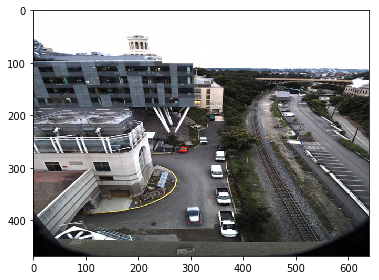

In [147]:
# Sample vreader at target frame.
sample_vreader = create_vreader(video_path, 24587)
img = next(sample_vreader)
skio.imshow(img)
skio.show()

In [148]:
target_shape = [1, 224, 224, 3]
data = resize(img, (224, 224))
data = img_as_ubyte(data).reshape(*target_shape)
feature_map_vals = get_network_outputs(net, data)

(28, 28, 256)


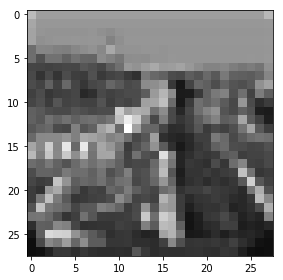

In [149]:
# Change to "normal" order (b, h, w, c).
feature_map_vals_grid = transpose_feature_map(feature_map_vals)
conv_features = feature_map_vals_grid['conv3_2/sep']
print(conv_features[0].shape)
feature_grid = feature_map_norm_grid(conv_features[0])
skio.imshow(feature_grid / np.max(feature_grid))
skio.show()

### Run Sample Train tracking

In [150]:
sample_vreader = create_vreader(video_path, 24587)
img_batch = [next(sample_vreader) for _ in range(32)]
img_batch = np.array(img_batch)

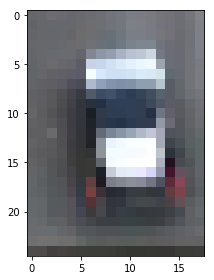

In [154]:
resized_img_batch = np.array(map(lambda x: img_as_ubyte(resize(x, (224, 224))), img_batch))
skio.imshow(resized_img_batch[0, 180:198, 1:115])
skio.show()

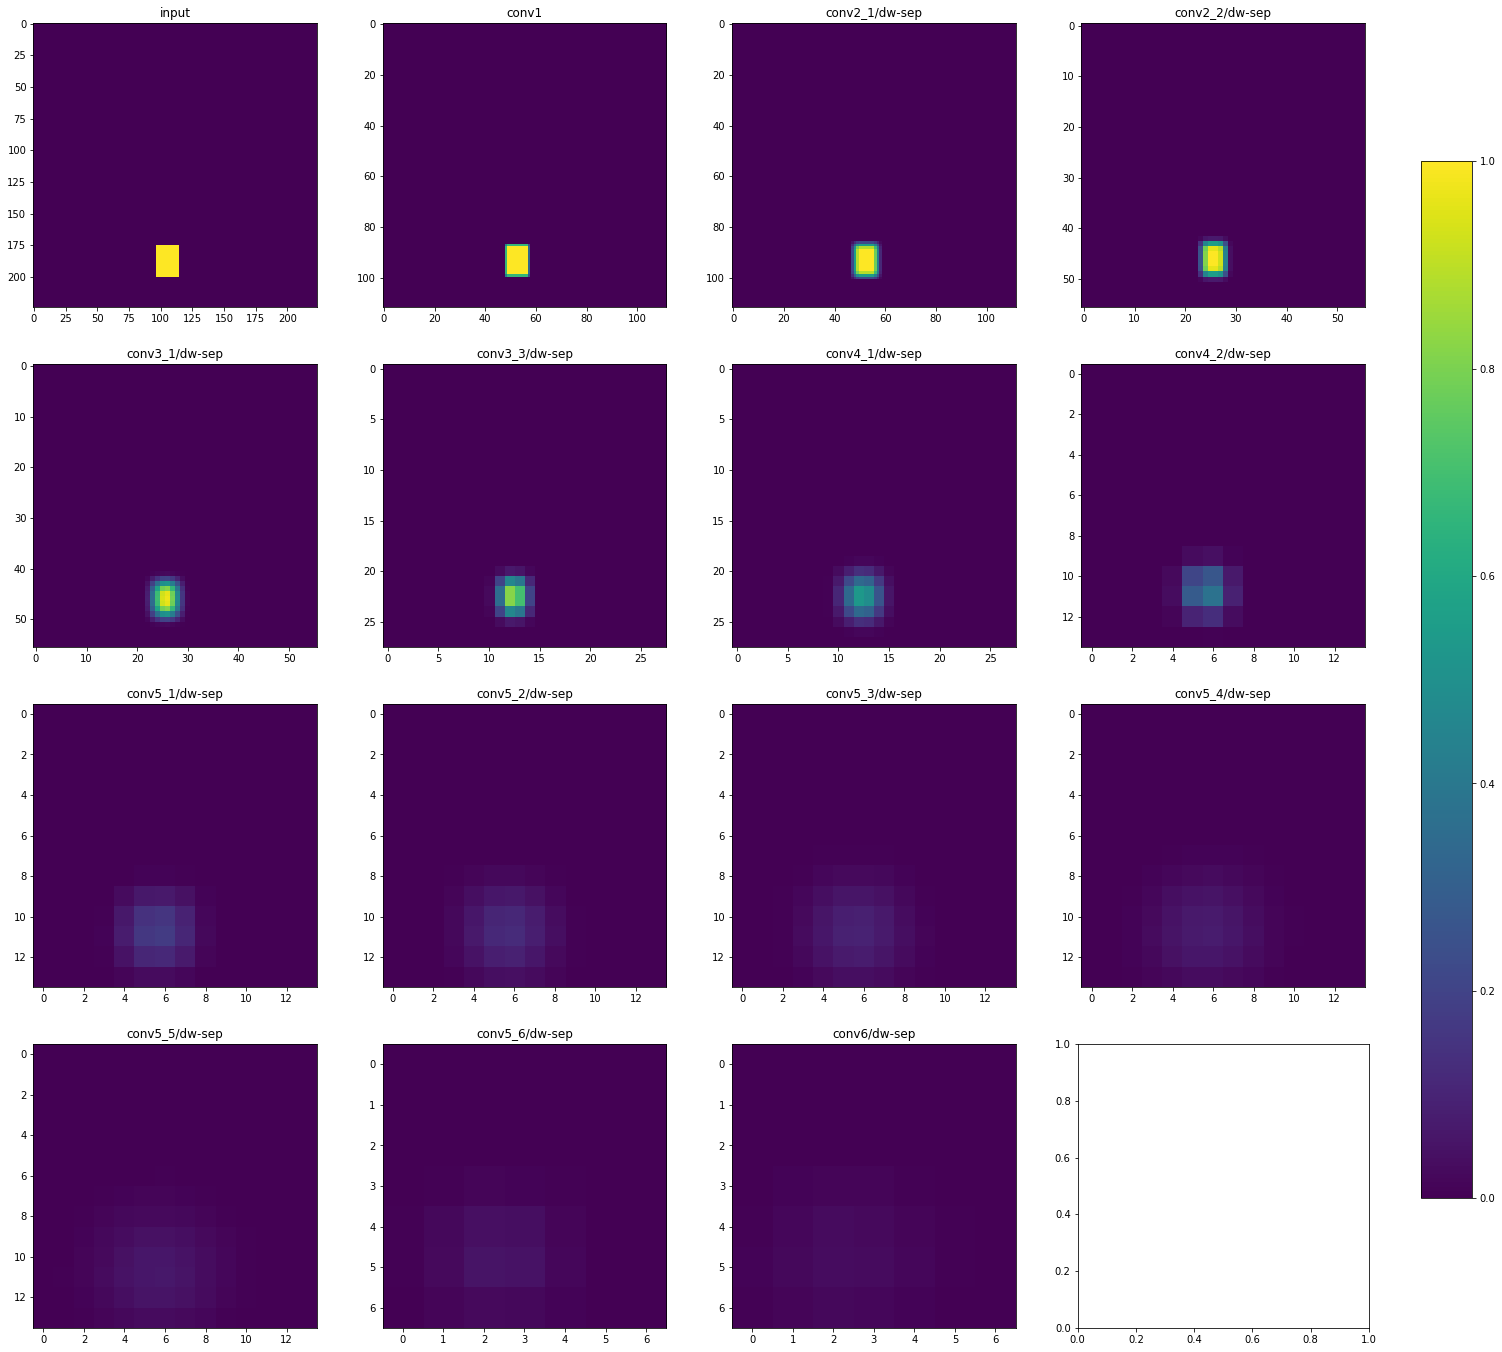

In [155]:
input_mask = np.zeros((1, 224, 224, 1))
input_mask[:, 175:200, 97:115, :] = 1
input_placeholder = tf.placeholder('float32', [1, 224, 224, 1])
conv_layers = apply_forward_convs(input_placeholder, mobilenet_layers)
conv_outputs = sess.run(conv_layers,
                        feed_dict={input_placeholder: input_mask})
input_layer = ('input', 1, 1, 1)
plot_conv_maps(resized_img, [input_mask] + conv_outputs,
               [input_layer] + mobilenet_layers, show_image=False, save_image=False)

In [156]:
data = resized_img_batch
data = normalize_mobilenet_input(data)
feature_map_vals = get_network_outputs(net, data)
feature_map_vals_grid = transpose_feature_map(feature_map_vals)
conv_features = feature_map_vals_grid['conv4_1/sep']
# Create template conv features and apply matching.
template_img = pad_img_with_mean(resized_img_batch[0, 175:200, 97:115], 32, 32)
template_img = normalize_mobilenet_input(template_img)
template_img = template_img.reshape([1] + list(template_img.shape))
template_features = get_network_outputs(net, template_img)
template_features = transpose_feature_map(template_features)
template = template_features['conv4_1/sep'][0]
template = template.reshape(list(template.shape) + [1])
# template_match_cc = cross_correlate(conv_features, template)
template_match_cc = squared_distance(conv_features, template)
template_match_cc = np.squeeze(template_match_cc)

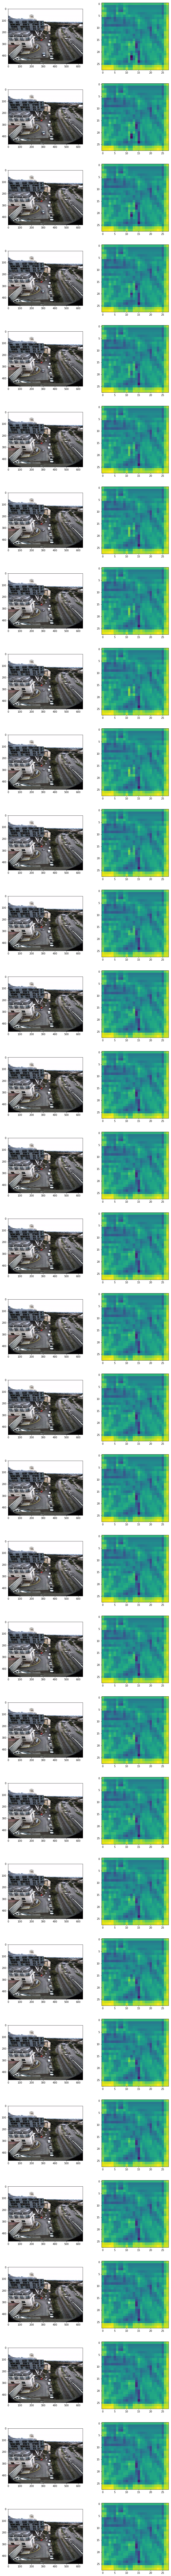

In [157]:
plot_imgs_and_grids(img_batch, template_match_cc)